In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import os
import cv2

import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
labels = ['Normal', 'Potholes']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
data = get_data('drive/MyDrive/Dataset')

'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


<ipython-input-3-4fc451c4081d>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [5]:
data_t = []
data_l = []
for feature, label in data:
  data_t.append(feature)
  data_l.append(label)


X_new = np.array(data_t)
y_new = np.array(data_l)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(X_new, y_new, test_size=0.40)

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [7]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [8]:
vggmodel = VGG16()

# freeze the first 15 layers of the VGG16 model
for layer in (vggmodel.layers)[:8]:
    layer.trainable = False

# remove the last output layer and add a new output layer
X = vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)

# define the final model
model_final = Model(inputs=vggmodel.input, outputs=predictions)

# compile the model
opt = Adam(lr=0.0001)
model_final.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])

# print the model summary
model_final.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
opt = Adam(lr=0.000001)
model_final.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [10]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [11]:
model_file = 'model/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'

#maximizing val_accuracy, store only the best models  
checkpoint = ModelCheckpoint(model_file, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

#If after 3 epochs the val_accuracy does not improve just stop 
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')

In [12]:
history = model_final.fit(x_train,y_train,epochs = 500,batch_size = 32, validation_data = (x_val, y_val), verbose = 2,shuffle = True,callbacks = [checkpoint,early])

Epoch 1/500


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



Epoch 1: val_accuracy improved from -inf to 0.98210, saving model to model/weights.01-0.98.hdf5
42/42 - 19s - loss: 0.6198 - accuracy: 0.7259 - val_loss: 0.2801 - val_accuracy: 0.9821 - 19s/epoch - 459ms/step
Epoch 2/500

Epoch 2: val_accuracy improved from 0.98210 to 0.99553, saving model to model/weights.02-1.00.hdf5
42/42 - 5s - loss: 0.1463 - accuracy: 0.9895 - val_loss: 0.0713 - val_accuracy: 0.9955 - 5s/epoch - 122ms/step
Epoch 3/500

Epoch 3: val_accuracy improved from 0.99553 to 0.99664, saving model to model/weights.03-1.00.hdf5
42/42 - 6s - loss: 0.0436 - accuracy: 0.9955 - val_loss: 0.0290 - val_accuracy: 0.9966 - 6s/epoch - 132ms/step
Epoch 4/500

Epoch 4: val_accuracy improved from 0.99664 to 0.99776, saving model to model/weights.04-1.00.hdf5
42/42 - 5s - loss: 0.0203 - accuracy: 0.9970 - val_loss: 0.0165 - val_accuracy: 0.9978 - 5s/epoch - 109ms/step
Epoch 5/500

Epoch 5: val_accuracy did not improve from 0.99776
42/42 - 2s - loss: 0.0123 - accuracy: 0.9985 - val_loss: 

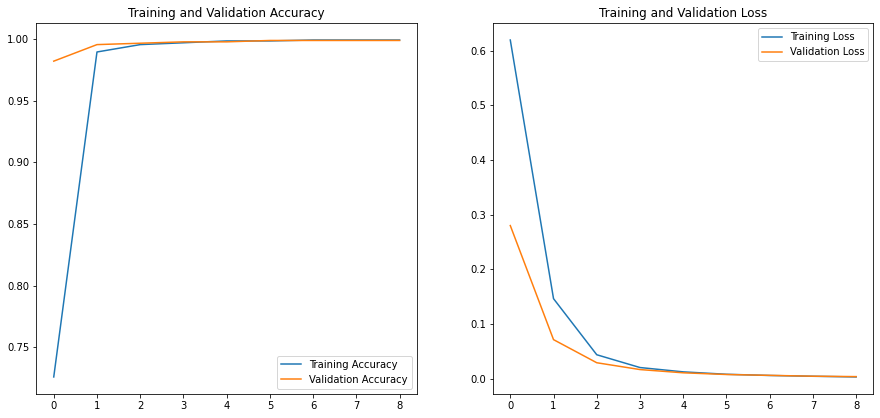

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(9)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
y_pred=model_final.predict(x_val)
y_pred=np.argmax(y_pred,axis=1)

28/28 [==============================] - 1s 20ms/step


In [15]:
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       438
           1       1.00      1.00      1.00       456

    accuracy                           1.00       894
   macro avg       1.00      1.00      1.00       894
weighted avg       1.00      1.00      1.00       894



In [16]:
print(confusion_matrix(y_pred,y_val))

[[437   1]
 [  0 456]]


In [17]:
def performance_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i] == y_hat[i]==1:
            TP += 1
        if y_hat[i] == 1 and y_actual[i] == 0:
            FP += 1
        if y_hat[i] == y_actual[i] == 0:
            TN +=1
        if y_hat[i] == 0 and y_actual[i] == 1:
            FN +=1

    return(TP, FP, TN, FN)

In [18]:
TP, FP, TN, FN = performance_measure(y_val,y_pred)

In [19]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC)

0.9978118161925602 1.0 1.0 0.997716894977169 0.0 0.002188183807439825 0.0 0.9988814317673378


In [20]:
from sklearn.metrics import roc_curve

In [21]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [22]:
from sklearn.metrics import auc
auc = auc(fpr, tpr)

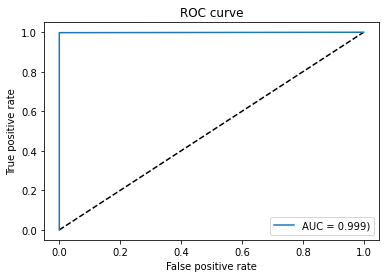

In [23]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()